# ADA Project : Creative Extension
## Chilling Effects : Online Surveillance and Wikipedia Use

In this notebook, we extend the analysis done in the paper by using an extended time range, and try to answer the following questions:

1. Is there a persistent, long-term chilling effect related to Snowden’s revelation?
2. Can we highlight new chilling effects due to other scandals?
3. What may be the other factors governing the traffic and how are they affecting the article views?

**Content**

[Data Acquisition and processing](#data)
- [Data Acquisition](#webScrape)
- [Data Preprocessing](#dataProcessing)

[Question 1](#q1)
- [Non-model empirical findings](#non_model_based)
- [Model-based empirical findings](#model_based)

[Question 2](#q2)

[Question 3](#q3)
- [Growth of Internet](#internetUsers)



In [1]:
#internal imports
import scraping

#external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIRECTORY = 'data/'
ARTICLES_TITLES = 'articles.txt'
TERRORISM_DATA = 'terrorism.csv'
INTERNET_USERS = 'worldInternetUsers.csv'

<a id="data"></a>
## Data Acquisition and processing
<a id="webScrape"></a>
### Web scraping

The first step is to scrape the website [wikipediaviews](https://wikipediaviews.org) in order to get monthly pageviews of the terrorism-related articles for the time range 2008-2018. Note that the data provided by this site is based on both `stats.grok.se` (for the period before June 2015) and the Wikimedia REST API (for the period after).

We will only consider the English Wikipedia and we ignore pageviews from mobile devices.

In [3]:
# We can scrape the data and save it in a CSV file using this function
#scrape_wikipedia_pageviews(2008, 1, 2018, 12, DATA_DIRECTORY, ARTICLES_TITLES, TERRORISM_DATA)

<a id="dataProcessing"></a>
### Data processing

In [4]:
terrorism_raw = pd.read_csv(DATA_DIRECTORY + TERRORISM_DATA, usecols=[1, 2, 3])
print(terrorism_raw.shape[0], 'lines')
terrorism_raw.sample(4)

6336 lines


,article,date,views
4407,palestine_liberation_front,2012-04,NaN
808,al-shabaab,2009-05,NaN
1148,attack,2015-09,964.0
5009,recruitment,2018-06,12094.0


In [5]:
# We handle the NaN values 
terrorism = terrorism_raw[~terrorism_raw.views.isna() & terrorism_raw.views != 0]
terrorism['date']= pd.to_datetime(terrorism['date'])  # convert date to datetime
print(terrorism.shape[0], 'lines')
terrorism.sample(4)

4105 lines


<ipython-input-5-e17e3dbecafe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terrorism['date']= pd.to_datetime(terrorism['date'])  # convert date to datetime


,article,date,views
638,al-qaeda_in_the_arabian_peninsula,2017-03-01,8487.0
910,al-shabaab,2017-11-01,330.0
2997,improvised_explosive_device,2015-10-01,357.0
4506,pirates,2009-07-01,29544.0


In [6]:
# read the internet users for each month 
internet_users = pd.read_csv(DATA_DIRECTORY + INTERNET_USERS, parse_dates=["Month"])
internet_users.set_index("Month", inplace=True)
internet_users.sample(4)

,Users,Percentage of World Population,Source
Month,,,
2008-12-01,1574000000,23.5,Internet World Stats
2010-06-01,1966000000,28.7,Internet World Stats
2013-12-01,2802000000,39.0,Internet World Stats
2017-06-01,3885000000,51.7,Internet World Stats


### Verifying Data

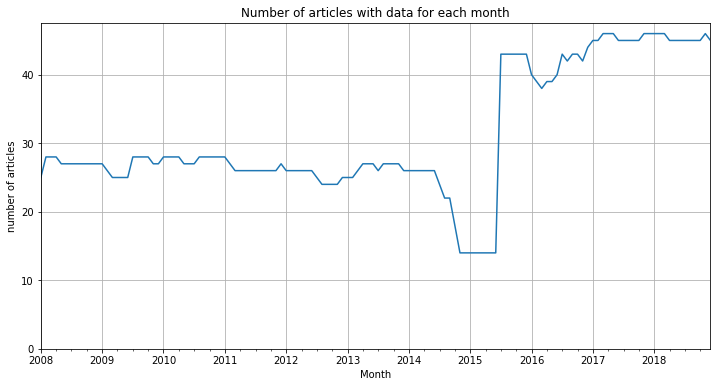

In [7]:
# first we need to compute number of articles per month
terrorism2 = terrorism.copy()
terrorism2.set_index("date", inplace=True)
terrorism_group_count = terrorism2.groupby("date").count() # now this has article count per each month
# now lest's plot the data
fig, ax = plt.subplots()
terrorism_group_count["article"].plot(ax=ax)
fig.set_size_inches(12, 6)
ax.set_ylim(bottom=0)
ax.set_title("Number of articles with data for each month")
ax.set_ylabel("number of articles")
ax.set_xlabel("Month")
ax.grid()

We have less number of articles before 2015 and after 2015, we have data for almost all the articles. We will consider this factor in the following questions

In [8]:
# lets try to remove articles where view counts are not present atleast 50% (~65 datapoints) of the time
terrorism3 = terrorism.copy()
article_count_df = terrorism3.groupby("article").count().views
articles_worth_considering = article_count_df[article_count_df>65].index
articles_worth_considering # the list of articles that have data for atleast 65 months

Index(['abu_sayyaf', 'afghanistan', 'al-qaeda',
       'al-qaeda_in_the_arabian_peninsula', 'ammonium_nitrate', 'attack',
       'biological_weapon', 'car_bomb', 'chemical_weapon', 'farc', 'hamas',
       'hezbollah', 'iran', 'iraq', 'islamist', 'nationalism', 'nigeria',
       'nuclear', 'pakistan', 'pirates', 'political_radicalism', 'recruitment',
       'somalia', 'suicide_attack', 'taliban', 'terror', 'terrorism', 'yemen'],
      dtype='object', name='article')

In [9]:
# new dataframe with articles in the above list
articles_worth_considering_df = terrorism3[terrorism3["article"].isin(articles_worth_considering)]

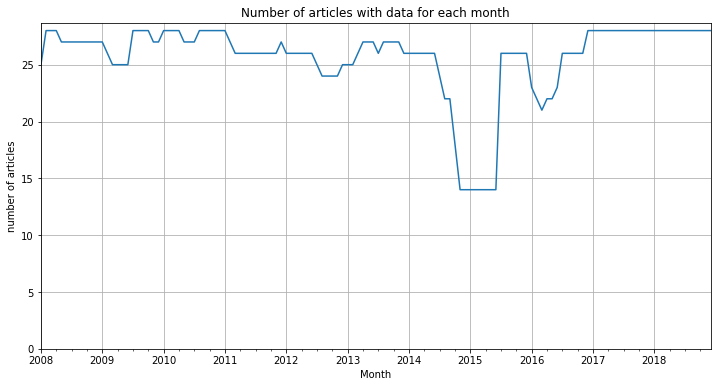

In [10]:
## todo: I think this is better to use, what do you think?

# first we need to compute number of articles per month
terrorism2 = articles_worth_considering_df.copy()
terrorism2.set_index("date", inplace=True)
terrorism_group_count = terrorism2.groupby("date").count() # now this has article count per each month
# now lest's plot the data
fig, ax = plt.subplots()
terrorism_group_count["article"].plot(ax=ax)
fig.set_size_inches(12, 6)
ax.set_ylim(bottom=0)
ax.set_title("Number of articles with data for each month")
ax.set_ylabel("number of articles")
ax.set_xlabel("Month")
ax.grid()

Now the plot looks better. However we still have the problem with very less articles in end of 2015 to mid 2016

<a id="q1"></a>
## Question 1 : Is there a persistant chilling effect ? 

In [11]:
#Now we sum the article viwes of the same month
terror_month = terrorism.groupby(["date"]).sum().reset_index()
terror_month['date']= pd.to_datetime(terror_month['date'])  # convert date to datetime
terror_month["num"] = np.arange(1, len(terror_month)+1)

<a id="non_model_based"></a>
## 1.1 Non-model empirical findings
Here, we present findings that do not rely on a statiscal model. We computed the average monthly number of views, before and after the june 2013 events

In [29]:
# we will add a column to the dataframe to indicate before or after the Snowden incident
terror_month["before_June_2013"] = terror_month["date"].apply(lambda x: 'Pre June 2013' if x < pd.to_datetime("2013-06-01") else 'Post June 2013')

Text(0.5, 1.0, 'Average views before and after June-2013 with 95% confidence interval')

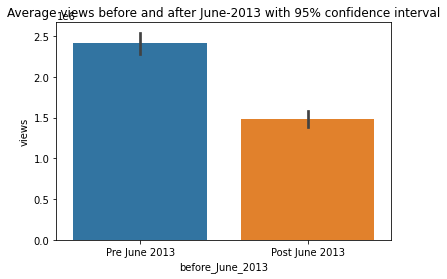

In [30]:
# now lest's plot the data
fig, ax = plt.subplots()
ax =sns.barplot(x="before_June_2013", y="views", data=terror_month)
ax.set_title("Average views before and after June-2013 with 95% confidence interval")

We can clearly notice a significant reduction after the revelations, which is also highlighted with 95% confidence interval. A reduction after the June 2013 surveillance revelations may suggest a chilling effect.

In [31]:
#create subsets, pre & post June 2013
data_pre = terror_month[terror_month.before_June_2013 == "Pre June 2013"]
data_post = terror_month[terror_month.before_June_2013 == "Post June 2013"]
avg_month_view = pd.DataFrame({'time':['Pre-june', 'Post-june'], 'avg':[data_pre.views.mean(), data_post.views.mean()]})
avg_month_view

,time,avg
0,Pre-june,2.420856e+06
1,Post-june,1.484429e+06


In [39]:
#average month views change in percent
avg_month_view.avg.pct_change()

0         NaN
1   -0.386816
Name: avg, dtype: float64

In [40]:
#average month views change
avg_month_view.avg.diff()

0              NaN
1   -936426.947187
Name: avg, dtype: float64

The difference in mean values before and after June 2013 is notable : We notice a reduction of **936426.9** in the average monthly views for the articles, which represents approximately a **38.7%** drop in article view counts.

<a id="model_based"></a>
## 1.2 Model-based empirical findings

We then performed an *Interrupted Time Series* (ITS) analysis, by fitting a linear regressor before and after our "iterruption" (here, the June 2013 revelations).

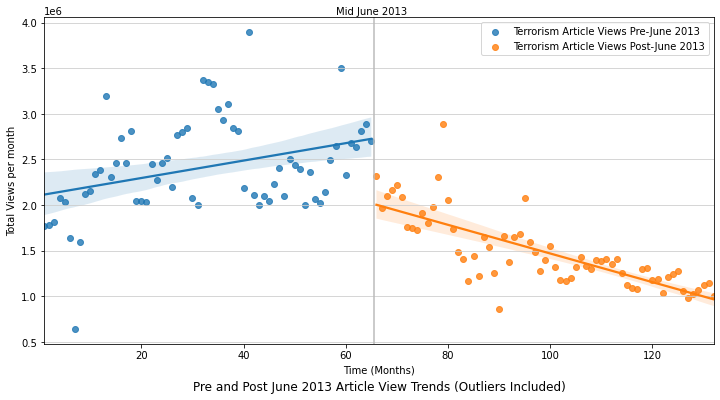

In [38]:
# now let's plot this result
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views", ax=ax, data=terror_month[:65], label="Terrorism Article Views Pre-June 2013")
sns.regplot(x="num", y="views", ax=ax, data=terror_month[65:], label="Terrorism Article Views Post-June 2013")

# line and marker at mid June 2013
ax.axvline(x=65.5, color="#bbbbbb") 
_, top = ax.get_ylim()
plt.text(58,top+3e4,'Mid June 2013')

# plot axises, legends and etc...
ax.set_title("Pre and Post June 2013 Article View Trends (Outliers Included)", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month")
ax.grid(axis='y',color='#cccccc')

 The sudden drop in views and trend shift from increasing monthly views over time to decreasing after June 2013 is consistent with a significant and long-term chilling effect. We also notice that we did not need to remove outliers to obtain results that are consistent with the chilling effect hypothesis. One can discuss if we also need to perform a ITS without the outliers.

<a id="q2"></a>
## Question 2 : other scandals ?

Potential other scandals we can highlight :

[2013 : Chelsea Manning sentenced to 35 years in prison](https://en.wikipedia.org/wiki/United_States_v._Manning)

[2017 : Vault 7](https://en.wikipedia.org/wiki/Vault_7)

[2018 : Cambridge analytica scandal](https://en.wikipedia.org/wiki/Facebook%E2%80%93Cambridge_Analytica_data_scandal)

[2019 : “the great hack” documentary on Netflix](https://en.wikipedia.org/wiki/The_Great_Hack#Reception)

[2019 : Julian assange arrest](https://en.wikipedia.org/wiki/Julian_Assange)

<a id="q3"></a>
## Question 3 : other factors governing the traffic
<a id="internetUsers"></a>
### Growth of Internet Users

One of the main factors that can affect the Wikipedia traffic will be the number of users. So let's first consider it

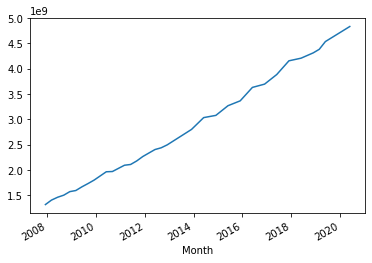

In [12]:
fig, ax = plt.subplots()
internet_users['Users'].plot(ax=ax)

Here we can see an almost linear relationship. We can do a small statistical test to confirm it.

In [18]:
# First we will add a new columns with number of months from 2008 Jan.
internet_users['nb_months'] = (internet_users.index- pd.to_datetime('2007-12-01') )/np.timedelta64(1, 'M')
internet_users['nb_months'] = internet_users['nb_months'].round() # to round the month count
internet_users.head(4)

,Users,Percentage of World Population,Source,nb_months
Month,,,,
2007-12-01,1319000000,20.0,Internet World Stats,0.0
2008-03-01,1407000000,21.1,Internet World Stats,3.0
2008-06-01,1463000000,21.9,Internet World Stats,6.0
2008-09-01,1504000000,22.5,Internet World Stats,9.0


In [20]:
# now we can do the regression
mod = smf.ols(formula='Users ~ nb_months', data=internet_users)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Users   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5962.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           5.21e-37
Time:                        21:43:10   Log-Likelihood:                -645.47
No. Observations:                  33   AIC:                             1295.
Df Residuals:                      31   BIC:                             1298.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.222e+09   2.36e+07     51.778      0.0

As predicted the two variables are highly corelated ($R^2$ value is 0.995) and also we can neglect the null hypothesis because the p value is zero.

And a **fun fact** is according to this, we can safely say internet users grows ~2.3 million each month!

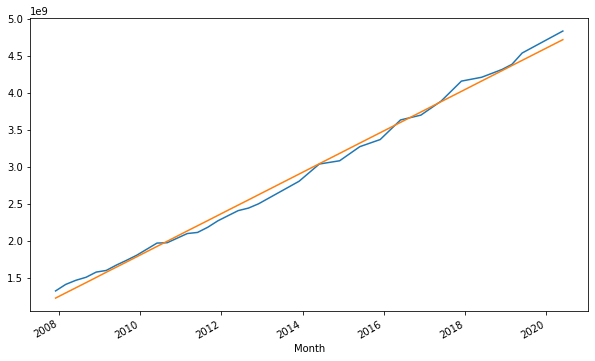

In [21]:
# now lets plot the linear regression line with the previous plot
bias, tangent = res.params
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
internet_users['Users'].plot(ax=ax)
ax.plot(internet_users.index, (internet_users['nb_months']*tangent+bias))

As we can see, we can see a very good match between the actual graph and the regression line. This is a very convinient result as now we can use the regression line for the analysis, thus eliminating the issue of some missing figures in the actual dataset.

In [75]:
# data_pre["internet_users"] = data_pre["num"]*tangent+bias
# data_post["internet_users"] = data_post["num"]*tangent+bias
terror_month["internet_users"] = terror_month["num"]*tangent+bias
terror_month["views_per_million_users"] = terror_month["views"]/terror_month["internet_users"]*1e6
terror_month.head(4)

,date,views,num,internet_users,views_per_million_users
0,2008-01-01,1770122.0,1,1.245405e+09,1421.322076
1,2008-02-01,1779044.0,2,1.268699e+09,1402.258026
2,2008-03-01,1810909.0,3,1.291994e+09,1401.639239
3,2008-04-01,2074790.0,4,1.315288e+09,1577.441781


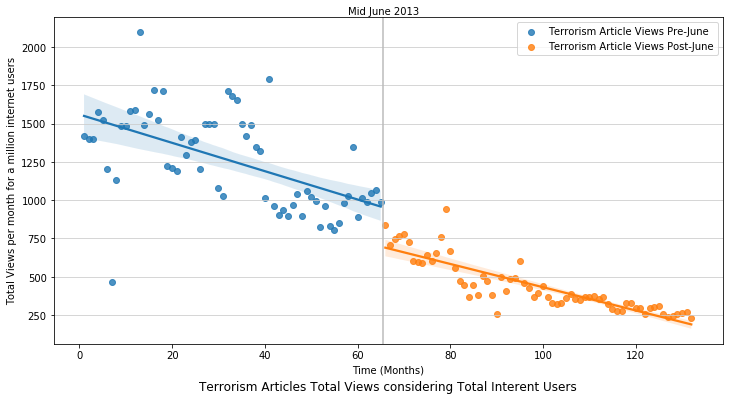

In [85]:
# now let's plot this result
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=terror_month[:65], label="Terrorism Article Views Pre-June")
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=terror_month[65:], label="Terrorism Article Views Post-June")

# line and marker at mid June 2013
ax.axvline(x=65.5, color="#bbbbbb") 
_, top = ax.get_ylim()
plt.text(58,top+20,'Mid June 2013')

# plot axises, legends and etc...
ax.set_title("Terrorism Articles Total Views considering Total Interent Users", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month for a million internet users")
ax.grid(axis='y',color='#cccccc')

This tells a different story than the conclusion we made above. Now the division between the two categories are not so significant. In other words, when we take the number of internet users in the world, the total traffic for these terrorism related articles have a negative trend.